In [72]:
!pip install numpy
!pip install matplotlib

3225.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


3230.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [73]:
import numpy as np
from matplotlib import pyplot as plt

N = 200
tmin = 1
tmax = 1000

def exp_sampling(N: float, Tmin: float = 1, Tmax: float = 1000) -> np.ndarray:
    n = np.arange(1, N + 1)
    T = Tmin * np.exp((-(n - 1) * np.log(Tmin / Tmax)) / (N - 1))
    return T

In [74]:
signal = np.zeros(N)

with open('signal.txt', 'r') as file:
    for i, line in enumerate(file):
        signal[i] = float(line)

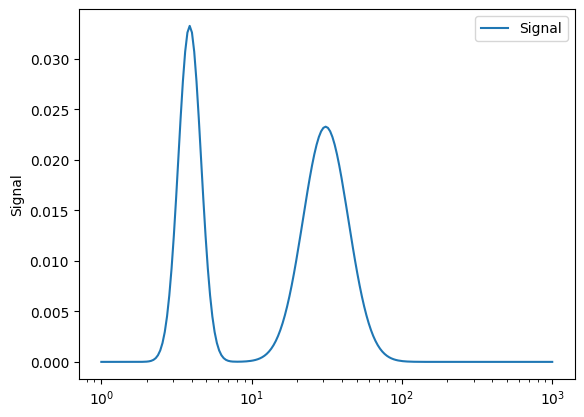

In [75]:
T = exp_sampling(N, tmin, tmax)
plt.plot(T, signal, label='Signal')
plt.xscale('log')
plt.ylabel('Signal')
plt.legend()
plt.show()

In [76]:
M = 50
tmin = 0
tmax = 1.5

def lin_sampling(M: float, tmin: float, tmax: float) -> np.ndarray:
    n = np.arange(1, M+1) 
    T = tmin + (n-1)*(tmax-tmin)/(M-1)
    return T

t = lin_sampling(M, tmin, tmax)

In [77]:
K = np.exp(-np.outer(t, T))

Text(0, 0.5, 'Value')

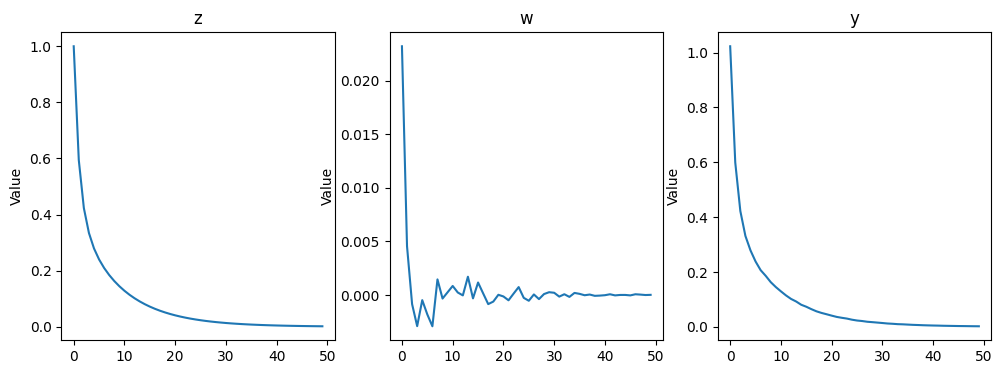

In [78]:
z = K @ signal
w = 0.01 * np.random.randn(M) * z
y = z + w

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(z)
axes[0].set_title("z")
axes[0].set_ylabel("Value")

axes[1].plot(w)
axes[1].set_title("w")
axes[1].set_ylabel("Value")

axes[2].plot(y)
axes[2].set_title("y")
axes[2].set_ylabel("Value")

## Comparison of regularization strategies

In [79]:
def grad_square_loss(K: np.ndarray, y: np.ndarray, x: np.ndarray) -> np.ndarray:
    return K.T @ (K @ x - y)

### grad smoothness approach

We solve the optimization problem using gradient descent

In [80]:
def smoothness_prior(x: np.ndarray) -> float:
    return 0.5 * np.sum(np.diff(x) ** 2) + 0.5 * (x[0] - x[-1])**2

def grad_smoothness_prior(x: np.ndarray) -> np.ndarray:
    return np.array([2*x[0] -x[1] - x[-1], *([2*x[i] - x[i-1] - x[i+1] for i in range(1, len(x)-1)]), 2*x[-1] - x[-2] - x[0]])

def loss_smoothness_prior(x: np.ndarray, y: np.ndarray, K: np.ndarray, w:np.ndarray, beta: float) -> float:
    return 0.5 * np.linalg.norm(K @ x - y)**2 + beta*smoothness_prior(x)

# test = np.array([i**2 for i in range(10)])
# print(grad_smoothness_prior(test))

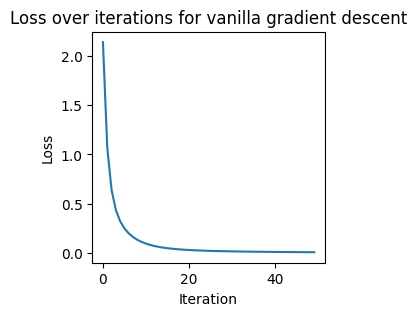

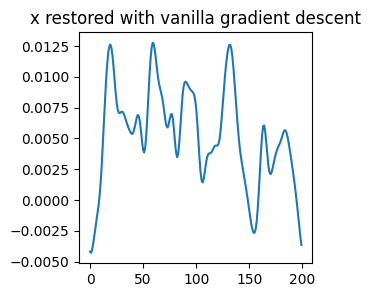

In [81]:
def grad_desc(K: np.ndarray, y: np.ndarray, beta: float, x0: np.ndarray, lr: float, n_iter: int) -> list:
    x = x0
    loss = []
    for i in range(n_iter):
        x = x - lr * (grad_square_loss(K, y, x) + beta * grad_smoothness_prior(x))
        loss.append(loss_smoothness_prior(x, y, K, w, beta))
    return x, loss

# Cheating a little since we use information from the true signal, but it allows us to avoid looking for a proper initialization
x0 = np.random.uniform(0, np.max(signal), N)

x_grad_desc, loss_grad_desc = grad_desc(K, y, 100, x0, 0.001, 50)
plt.figure(figsize=(3,3))
plt.plot(loss_grad_desc)
plt.title("Loss over iterations for vanilla gradient descent")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

plt.figure(figsize=(3,3))
plt.plot(x_grad_desc)
plt.title("x restored with vanilla gradient descent")
plt.show()

In [82]:
def normalized_quadratic_error(x_true: np.ndarray, x_restored: np.ndarray) -> float:
    return np.linalg.norm(x_true - x_restored)**2 / np.linalg.norm(x_true)**2

print("normalized quadratic error obtained with projected GD and ",normalized_quadratic_error(signal, x_grad_desc))

normalized quadratic error obtained with projected GD and  0.8240691470275483


### smoothness prior + constraints

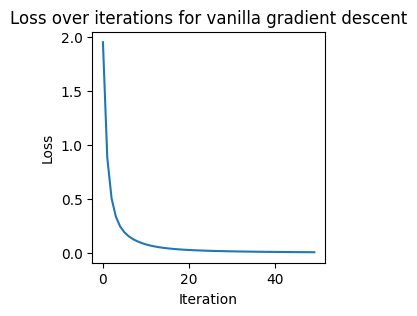

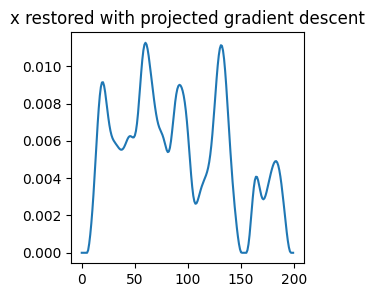

In [83]:
def projected_grad_desc(K: np.ndarray, y: np.ndarray, beta: float, x0: np.ndarray, lr: float, n_iter: int) -> np.ndarray:
    x = x0
    loss = []
    for i in range(n_iter):
        x = x - lr * (grad_square_loss(K, y, x) + beta * grad_smoothness_prior(x))
        x = np.clip(x, np.min(signal), np.max(signal))
        loss.append(loss_smoothness_prior(x, y, K, w, beta))
    return x, loss

x_projected_grad_desc, loss_projected_grad_desc = projected_grad_desc(K, y, 200, x0, 0.001, 50)
plt.figure(figsize=(3,3))
plt.plot(loss_projected_grad_desc)
plt.title("Loss over iterations for vanilla gradient descent")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()


plt.figure(figsize=(3,3))
plt.plot(x_projected_grad_desc)
plt.title("x restored with projected gradient descent")
plt.show()

In [84]:
print("normalized quadratic error obtained with projected GD and ",normalized_quadratic_error(signal, x_projected_grad_desc))

normalized quadratic error obtained with projected GD and  0.7705182384040647


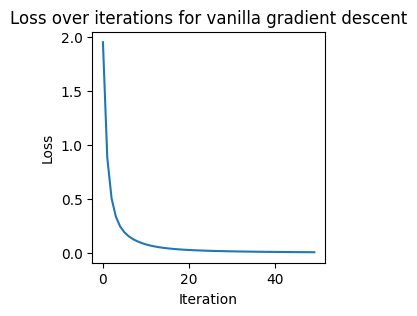

In [85]:
# 3. Proximal GD ?
plt.figure(figsize=(3,3))
plt.plot(loss_projected_grad_desc)
plt.title("Loss over iterations for vanilla gradient descent")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()